# Assignment 1: Data Parsing, Cleansing and Integration
## Task 1 and 2

Environment: Python 3 and Jupyter notebook

Main Libraries used in Task 1 and Task 2:
* pandas
* re
* numpy
* xml.etree.ElementTree
* difflib
* datetime
* seaborn
* matplotlib.pyplot

## Introduction
#### Goal of Task 1 and 2:
The goal of these 2 tasks is to parse in an xml file containing job posting information, clean the fields and format into a specific format, outlined in the assignment description. 

#### Problems encountered:
The problems encountered where numerous, requiring extensive data cleaning during and after being parsed into a pandas dataframe. This included:
* Adjusting the parsing to accommodate different columns in the xml records. Not all fields were included in some, resulting in missing fields for some but not all records.
* Cleaning string fields that did not contain proper structure or information - for example, Job title having numbers or incorrect text like 'test'
* Checking for spelling errors of unfamiliar data points like location using similarity scores to avoid manual checks across thousands of locations. Then applying the closest match based on the similarity score to correct any misspelt locations.
* Numerical data having different units of measure or entry

#### Approaches to handle data errors:
* Cleaning string fields to have consistent structure or consistent categories
* Checking for spelling errors using similarity scores
* Understanding the distribution of numerical fields like Salary and identifying outliers
* Cleaning company names and removing unnecessary information which may be an obstacle to similarity scores such as comany endings/suffices (e.g. pty,ltd, llc)
* Replacing blanks or NULL values with an appropriate text replacement, such as 'non-specified'
* Cleaning salary data from different units of measure or entry (e.g. $10000 v $10k v $20 per hour) and normalising the data
* Using univariate analysis to understand the distribution of values
* Cleaning date and time fields and analysing for logical errors



## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment

# Data cleaning and tidying libraries
import numpy as np #linear algebra
import pandas as pd #datapreprocessing, CSV file I/O
import xml.etree.ElementTree as etree # parsing XML formats
import difflib # comparing text
from datetime import datetime

# Regular Expression Library
import re

# Data visualisation libraries
import seaborn as sns #for plotting graphs
import matplotlib.pyplot as plt 

# Display DataFrame without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Display all columns and rows
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## Task 1. Parsing Data, explore dataset, identify format

In Task 1, we are loading in the raw XML file and parsing into a pandas dataframe. As the raw records show, there are challenges with 'missing fields', so a function has been built to overcome this. 

This section has the below steps:
* 1.1 Examining and loading data
* 1.2 Parsing data into the required format

### 1.1. Examining and loading data

In [2]:
# Code to inspect the provided data file
xml_tree = etree.parse("s3932835_dataset1.xml")  
root = xml_tree.getroot()

In [3]:
# This function gets a unique list (set) of all the field names (tags) for each record (grandchild).
# This is useful to cross-check the unique fields in the raw data compared to the final fields provided in the assignment text. 

def collect_tags(xml_root):
    child_counter = 0
    gc_counter = 0
    fields = set()
    for child in xml_root:
        child_counter += 1
        for gc in child:
            gc_counter += 1
            for col in gc:
                fields.add(col.tag)
    return child_counter, gc_counter, fields

# Run function
child_counter, gc_counter, column_names = collect_tags(root)

# Print result
print("Unique columns:", column_names)
print("Child counter:", child_counter)
print("Grandchild counter:", gc_counter)

# We can expect a maximum of 9 unique fields and 50,753 unique records

Unique columns: {'Company', 'Title', 'Id', 'Location', 'Salary', 'Date', 'ContractType', 'ContractTime', 'Category'}
Child counter: 107
Grandchild counter: 50753


In [4]:
# Let's have a quick look at some entries.
# We are looking at the first record (child) and its first field (grandchild)

for gc in root[0][0]: # root = root, root[0] = child, root[0][0] = grandchild
    print("Tag: ", gc.tag, "Text: ",gc.text)

# Here we can see that there are 6 elements or field names.
# Date appears as 'None' but in the raw data there is more to it.

Tag:  Id Text:  67770713
Tag:  Title Text:  CNC Programmer (Offline)
Tag:  Location Text:  Birmingham
Tag:  Category Text:  Engineering Jobs
Tag:  Salary Text:  32000
Tag:  Date Text:  None


In [5]:
# Let's look at another entry for comparison
# We are looking at the 2nd record (child) and its first field (grandchild)

for gc in root[1][0]:
    print("Tag: ", gc.tag, "\t\t Text: ",gc.text)

# Here we can see that there are 9 elements or field names, that is, 3 more than entry 1. 
# This means that not all entries have the same data provided, so there are missing data points.
# For contract type and contract time, these have spaces.
# Also, for Date, there is None, but in the raw data there is more to it.

Tag:  Id 		 Text:  69792473
Tag:  Title 		 Text:  Norwegian speaking Customer Services Advisor
Tag:  Location 		 Text:  Manchester
Tag:  Company 		 Text:  RentalCars.com
Tag:  ContractType 		 Text:  -
Tag:  ContractTime 		 Text:  permanent
Tag:  Category 		 Text:  Accounting & Finance Jobs
Tag:  Salary 		 Text:  21000
Tag:  Date 		 Text:  None


### 1.2 Parsing data into the required format

In [6]:
# Create a list of dictionaries from the XML data

# Create an empty list to store the dictionaries
records = []

# Loop through each record (child) and append the dictionary to the list
# Each record will be a dictionary with the field names as keys and the field values as values
# The final output will be a list of dictionaries


for record in root.findall('.//Record'): # find all records (child)
    rec = {} # create empty dictionary
    for child in record: # loop through each field (child)
        # if the field is Date, then we need to get the Open and Close values
        if child.tag == 'Date': 
            rec['OpenDate'] = child.attrib['Open']
            rec['CloseDate'] = child.attrib['Close']
        else:
            # If the tag is not date, then we can apply the tag and text to the dictionary. 
            # If the tag does not exist yet, then add the tag and text to the dictionary and all other fields are filled with NaN values.
            rec[child.tag] = child.text 
    records.append(rec) # append the dictionary to the list

# As a final step, we can convert the list of dictionaries to a DataFrame
df = pd.DataFrame(records)

# Adjust the order of the columns
df = df[['Id', 'Title', 'Location', 'Company', 'ContractType', 'ContractTime', 'Category', 'Salary', 'OpenDate','CloseDate']]
df.head()

# We have now parsed the raw xml file into a pandas dataframe. There has not yet been any cleaning or tidying of the data.

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate
0,67770713,CNC Programmer (Offline),Birmingham,NaN,NaN,NaN,Engineering Jobs,32000,20130610T150000,20130710T150000
1,69026322,Weekend Engineering Team Leader,Essex,NaN,NaN,NaN,Engineering Jobs,39000,20120515T120000,20120529T120000
2,67770033,Junior Writer,Nottingham,NaN,NaN,NaN,"PR, Advertising & Marketing Jobs",16500,20130617T000000,20130717T000000
3,69025763,Net Developer Manchester (Up To pound;****K ...,Manchester,NaN,NaN,NaN,IT Jobs,38000,20120221T120000,20120306T120000
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,Bath,NaN,NaN,NaN,Hospitality & Catering Jobs,16000,20130327T150000,20130410T150000


In [7]:
# Append 'SourceName' as a field to the DataFrame
df['SourceName'] = 'britishjobsonthe.net'

In [8]:
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,67770713,CNC Programmer (Offline),Birmingham,NaN,NaN,NaN,Engineering Jobs,32000,20130610T150000,20130710T150000,britishjobsonthe.net
1,69026322,Weekend Engineering Team Leader,Essex,NaN,NaN,NaN,Engineering Jobs,39000,20120515T120000,20120529T120000,britishjobsonthe.net
2,67770033,Junior Writer,Nottingham,NaN,NaN,NaN,"PR, Advertising & Marketing Jobs",16500,20130617T000000,20130717T000000,britishjobsonthe.net
3,69025763,Net Developer Manchester (Up To pound;****K ...,Manchester,NaN,NaN,NaN,IT Jobs,38000,20120221T120000,20120306T120000,britishjobsonthe.net
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,Bath,NaN,NaN,NaN,Hospitality & Catering Jobs,16000,20130327T150000,20130410T150000,britishjobsonthe.net


We cna cross check manually the first entry.
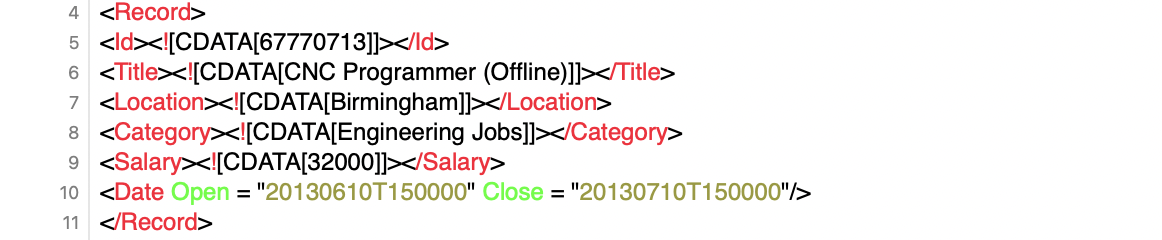

In [9]:
df.tail()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
50748,68704692,Graduate SoftwareWeb Developer,London,UNKNOWN auto added by vacany import,,,IT Jobs,25000,20120112T120000,20120312T120000,britishjobsonthe.net
50749,72653751,Barclays Future Leaders Development Programmes,Hackney,Barclays,,,IT Jobs,36000,20130721T150000,20130919T150000,britishjobsonthe.net
50750,72420369,Graduate Operations Technical Analyst,Hungerford,UNKNOWN auto added by vacany import,,,IT Jobs,23000,20130913T150000,20131112T150000,britishjobsonthe.net
50751,72653749,GCHQ Graduate Technologists various roles,Cheltenham,GCHQ,,,Engineering Jobs,25400,20120412T000000,20120611T000000,britishjobsonthe.net
50752,66372417,Graduate Engineer (Water industry),South Lanarkshire,Carrington West Limited,full_time,contract,Engineering Jobs,20000,20130119T000000,20130419T000000,britishjobsonthe.net


By doing manual spot checks, we can see the last entry in the dataframe matches the last entry in the raw file.

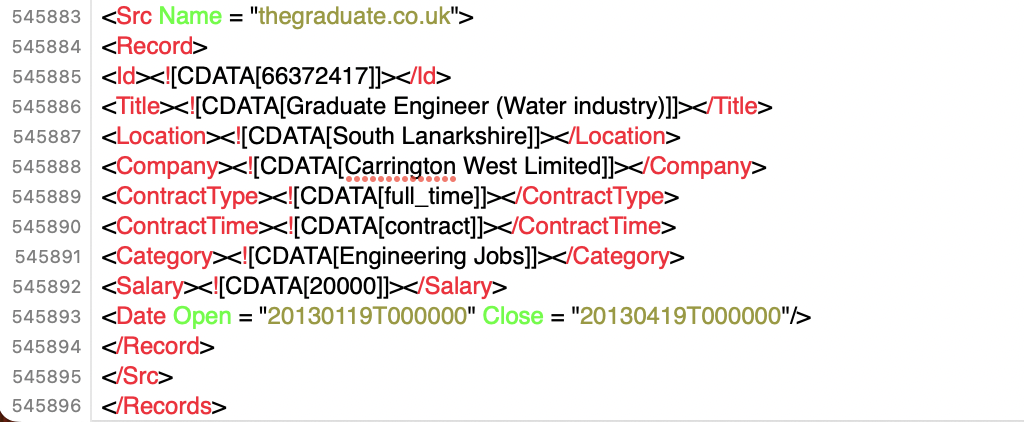

## Task 2. Auditing and cleansing the loaded data

In Task 2, we are cleaning the data thoroughly. This means scrutinising all fields, both text fields and numerical fields, identifying data gaps and conflicts, and cleaning. Each error is recorded into an error report.

In this section, the below steps are:
* 2.1 Create an Error List
* 2.2 Check ID Field
* 2.3 Clean Job Title Field
* 2.4 Clean Location Field
* 2.5 Clean Company Field
* 2.6 Cleaning ContractType and ContractTime Fields
* 2.7 Cleaning Category Field
* 2.8 Cleaning Salary Field
* 2.9 Cleaning Open and Close Date Fields
* Saving Data as CSV outputs.

### 2.1 Create an Error List

In [10]:
# Create an empty error list and the function to update it
itemlist = ['indexOfdf','ColumnName', 'Orignal', 'Modified', 'ErrorType','Fixing']
erlist = pd.DataFrame(columns=itemlist)
erlist

# Function to update error list
def updateErlist(indexOfdf, ColumnName, Orignal, Modified, ErrorType, Fixing):
    errItem=[indexOfdf,ColumnName, Orignal, Modified, ErrorType,Fixing]
    erlist.loc[len(erlist)]=errItem

#updateErlist(indexOfdf=''
#             , ColumnName= ''
#             , Orignal=''
#             , Modified=''
#             , ErrorType=''
#             , Fixing='') 

In [11]:
erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing


### 2.2 Check ID Field

In [12]:
# current state of the data frame, prior to cleaning and transformation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50753 entries, 0 to 50752
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            50753 non-null  object
 1   Title         50753 non-null  object
 2   Location      50753 non-null  object
 3   Company       47789 non-null  object
 4   ContractType  45661 non-null  object
 5   ContractTime  46341 non-null  object
 6   Category      50753 non-null  object
 7   Salary        50617 non-null  object
 8   OpenDate      50753 non-null  object
 9   CloseDate     50753 non-null  object
 10  SourceName    50753 non-null  object
dtypes: object(11)
memory usage: 4.3+ MB


In [13]:
# Check if values in the Id column are only numeric values
# If not, then we need to fix it

def filter_non_numerical_index(df):
    # Use a regular expression to match non-numerical characters
    non_numerical_pattern = re.compile(r'\D')
    
    # Apply the regular expression to the 'index' column and filter the DataFrame
    filtered_df = df[df['Id'].astype(str).str.contains(non_numerical_pattern)]
    
    return filtered_df

# Filter non-numerical index values
filtered_df = filter_non_numerical_index(df)
filtered_df

# We can conclude that all the Ids in the 'Id' column are numerical values

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName


In [14]:
# check length of 'Id' column values
df['Id'].astype(str).str.len().value_counts()

8    50753
Name: Id, dtype: int64

In [15]:
# convert the 'Id' column to 8 digit integers
df['Id'] = df['Id'].astype(str).str.zfill(8).astype(int)

### 2.3 Clean Job Title Field

Text(0.5, 1.0, 'Distribution of Title Lengths')

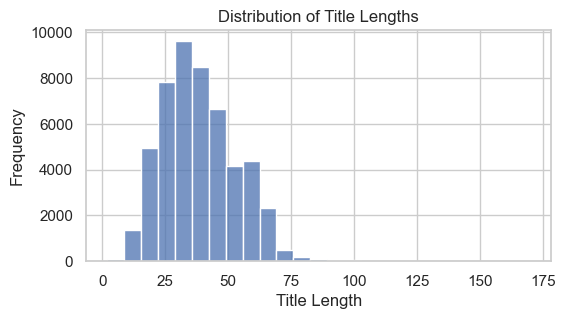

In [16]:
title_lengths = df['Title'].apply(len)

# Convert title_lengths to a new DataFrame
title_lengths_df = pd.DataFrame({'Title_Length': title_lengths})

# Create a Seaborn histogram
sns.set(style="whitegrid")
plt.figure(figsize=(6, 3))
num_bins = 25  # Define the number of bins
hist = sns.histplot(data=title_lengths, bins=num_bins)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Distribution of Title Lengths')



In [17]:
# Function to generate value counts table for a specific count of bins
def get_value_counts_table(num_bins):
    # Create a new DataFrame with the title lengths
    title_lengths_df = pd.DataFrame({'Title_Length': title_lengths})
    
    # Use pd.cut() to categorize data into bins
    title_lengths_df['Bin'], bin_edges = pd.qcut(title_lengths_df['Title_Length'], q=num_bins, retbins=True)
    
    # Count values in each bin using pd.value_counts()
    bin_counts = title_lengths_df['Bin'].value_counts().sort_index()
    
    # Create a DataFrame for the table of bin counts
    bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges) - 1)]
    bin_counts_table = pd.DataFrame({'Bin': bin_labels, 'Frequency': bin_counts.values})
    
    return bin_counts_table

# Specify the number of bins
num_bins = 25

# Get the value counts table for the specified number of bins
value_counts_table = get_value_counts_table(num_bins)

# Display the value counts table
print(value_counts_table)

       Bin  Frequency
0     2-17       2420
1    17-20       2090
2    20-22       1912
3    22-24       2337
4    24-26       2626
5    26-27       1441
6    27-28       1412
7    28-30       2807
8    30-31       1335
9    31-33       2748
10   33-34       1414
11   34-36       2657
12   36-37       1244
13   37-39       2402
14   39-41       2324
15   41-43       2228
16   43-45       2041
17   45-47       1838
18   47-49       1723
19   49-52       2181
20   52-55       1990
21   55-58       1991
22   58-61       1856
23   61-66       1982
24  66-170       1754


In [18]:
# filter df on title where the title length is less than 5 or does not contain letters
filtered_df = df[(df['Title'].str.len() < 5) | (df['Title'].str.contains(r'[a-zA-Z]') == False)]
filtered_df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
771,71429630,CNC,High Wycombe,Skillframe Ltd.,-,permanent,Engineering Jobs,21120,20120602T000000,20120702T000000,britishjobsonthe.net
3447,71428522,ALM,South East London,Michael Page Financial Services,-,permanent,Accounting & Finance Jobs,80000,20121016T150000,20130114T150000,britishjobsonthe.net
11522,50870368,****,UK,Rullion Engineering Ltd,-,permanent,Engineering Jobs,34500,20130903T120000,20131202T120000,britishjobsonthe.net
11859,69004885,HR,UK,Supreme Recruitment,-,permanent,Teaching Jobs,35000,20121129T150000,20130128T150000,britishjobsonthe.net
11947,70764257,RSCN,Manchester,HCL Nursing,-,contract,Healthcare & Nursing Jobs,54720,20120202T000000,20120303T000000,britishjobsonthe.net


In [19]:
# After spot checking, edit 2 entries where there are clear errors and convert title to 'non-specified'
df.loc[df['Id'] == 50870368, 'Title'] = 'non-specified'
df.loc[df['Id'] == 68584140, 'Title'] = 'non-specified'

In [20]:
# filter on df where id is 50870368 or 68584140
df[(df['Id'] == 50870368) | (df['Id'] == 68584140)]

# Update error list
updateErlist(indexOfdf=50870368
             , ColumnName= 'Title'
             , Orignal='****'
             , Modified='non-specified'
             , ErrorType='Typographical Error'
             , Fixing='Converted to non-specified')

updateErlist(indexOfdf=68584140
                , ColumnName= 'Title'
                , Orignal='test'
                , Modified='non-specified'
                , ErrorType='Data Imputation Error'
                , Fixing='Converted to non-specified')


In [21]:
erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified


### 2.4 Clean Location Field

In [22]:
# convert to lower case
df['Location']= df['Location'].str.lower()

# Count the number of unique values in the 'Location' column
# show all unique values
df['Location'].value_counts()

uk                   7721
london               6574
south east london    2665
the city             1144
central london        829
                     ... 
warringtn               1
londn                   1
manchaster              1
cembridge               1
croydan                 1
Name: Location, Length: 488, dtype: int64

<Axes: xlabel='Location'>

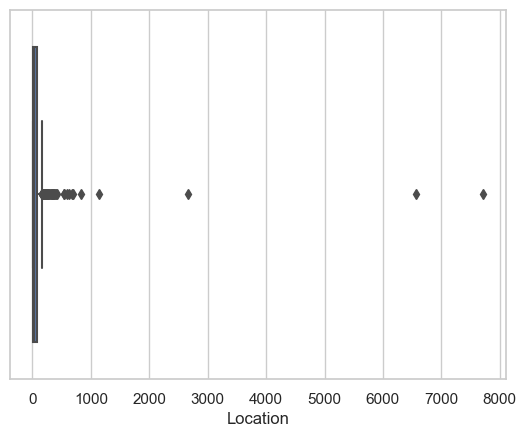

In [23]:
# add in boxplot to show outliers using seaborn
sns.boxplot(x=df['Location'].value_counts())

Text(0.5, 1.0, 'Distribution of Location Counts')

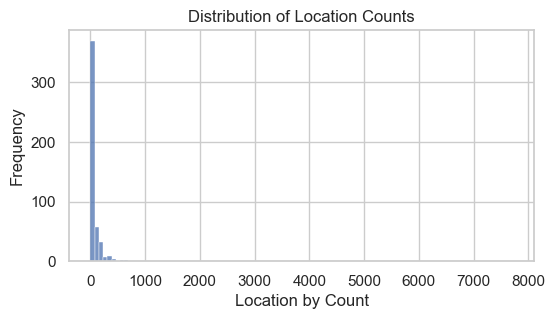

In [24]:
loc_counts = df['Location'].value_counts()

# Convert title_lengths to a new DataFrame
loc_lengths_df = pd.DataFrame({'Location Count': loc_counts})

# Create a Seaborn histogram
sns.set(style="whitegrid")
plt.figure(figsize=(6, 3))
num_bins = 100  # Define the number of bins
hist = sns.histplot(data=loc_counts, bins=num_bins)
plt.xlabel('Location by Count')
plt.ylabel('Frequency')
plt.title('Distribution of Location Counts')


In [25]:
# check missing values in location
df['Location'].isnull().sum()

0

In [26]:
# filter on df where location value counts are less than 5
unusual_locs = df['Location'].value_counts()[df['Location'].value_counts() < 5]

replace_dict = {}
# create loop and print out the best match for each unusual location, using the difflab library
for loc in unusual_locs.index:
    closest_match = difflib.get_close_matches(loc,set(df['Location']).difference([loc]), n = 1,cutoff=0.7)

    # Save the best match in the replace_dict
    replace_dict[loc]=closest_match[0]
    print(loc, " --> ",closest_match)

print("\n Replacement Dictionary: ",replace_dict)


leads  -->  ['leeds']
oxfords  -->  ['oxford']
livepool  -->  ['liverpool']
hampshira  -->  ['hampshire']
warringtn  -->  ['warrington']
londn  -->  ['london']
manchaster  -->  ['manchester']
cembridge  -->  ['cambridge']
croydan  -->  ['croydon']

 Replacement Dictionary:  {'leads': 'leeds', 'oxfords': 'oxford', 'livepool': 'liverpool', 'hampshira': 'hampshire', 'warringtn': 'warrington', 'londn': 'london', 'manchaster': 'manchester', 'cembridge': 'cambridge', 'croydan': 'croydon'}


In [27]:
# filter on df where location is in the replace_dict
# We can see that in the title description, sometimes the correct location is mentioned
df[df['Location'].isin(replace_dict.keys())]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
4339,72445824,Commercial Service Engineers combustion and p...,leads,Wright Choice Recruitment,-,permanent,Engineering Jobs,30000,20120206T120000,20120307T120000,britishjobsonthe.net
17260,72160747,Microsoft Developer,warringtn,TEKsystems,-,permanent,IT Jobs,22500,20120729T120000,20121027T120000,britishjobsonthe.net
19984,69622408,Regional Operations Manager Oxfordshire Oxford,oxfords,Gilbert Meher ltd,full_time,N/A,Healthcare & Nursing Jobs,60000,20121216T150000,20130115T150000,britishjobsonthe.net
20112,67151786,Operating Theatre (Endoscopy) Practitioner Ox...,oxfords,Medic International,full_time,N/A,Healthcare & Nursing Jobs,27500,20121118T120000,20130117T120000,britishjobsonthe.net
26183,70782597,Network Security Engineer ********k Leeds,leads,Fruition IT Resources Limited,-,permanent,IT Jobs,42500,20130728T120000,20130926T120000,britishjobsonthe.net
28512,69213042,Management Accountant 15 month contract,livepool,Reed Specialist Recruitment,full_time,permanent,Accounting & Finance Jobs,37500,20131028T120000,20131127T120000,britishjobsonthe.net
28666,69574218,Head of Underwriting Development Life,londn,High Finance Group,,permanent,Accounting & Finance Jobs,66000,20120621T120000,20120820T120000,britishjobsonthe.net
30837,71845755,Front Office Manager International Hotel Grou...,hampshira,JAP Associates,,,Hospitality & Catering Jobs,21000,20130212T150000,20130226T150000,britishjobsonthe.net
33117,68834722,Assistant ManagerBranded RestaurantsHants****k,hampshira,"Berkeley Scott Pubs, Bars & Restaurants",NaN,NaN,Hospitality & Catering Jobs,23500,20120329T150000,20120428T150000,britishjobsonthe.net
36788,70677425,Unix / Linux support engineer (with SQL) Salford,manchaster,Applause IT Limited,N/A,permanent,IT Jobs,24500,20130212T000000,20130413T000000,britishjobsonthe.net


In [28]:
# save the Id, incorrect location and correct location in a dataframe for the error report

# filter the dataframe and subset on Id and location. Then create a new column with the correct location using the dictionary
error_df = df[df['Location'].isin(replace_dict.keys())][['Id','Location']]
error_df['Correct_Location'] = error_df['Location'].map(replace_dict)
error_df

# This will become our error list


,Id,Location,Correct_Location
4339,72445824,leads,leeds
17260,72160747,warringtn,warrington
19984,69622408,oxfords,oxford
20112,67151786,oxfords,oxford
26183,70782597,leads,leeds
28512,69213042,livepool,liverpool
28666,69574218,londn,london
30837,71845755,hampshira,hampshire
33117,68834722,hampshira,hampshire
36788,70677425,manchaster,manchester


In [29]:
# Spot check these suggestions and update the location column
df['Location'].replace(replace_dict,inplace=True)
df['Location'].value_counts()

uk                   7721
london               6575
south east london    2665
the city             1144
central london        829
                     ... 
grimsby                 9
normanton               9
twickenham              9
waterlooville           8
north finchley          7
Name: Location, Length: 479, dtype: int64

In [30]:
# add each entry to the error log
for index, row in error_df.iterrows():
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'Location'
                 , Orignal=row['Location']
                 , Modified=row['Correct_Location']
                 , ErrorType='Typographical Error'
                 , Fixing='Converted to '+row['Correct_Location'])

erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified
2,72445824,Location,leads,leeds,Typographical Error,Converted to leeds
3,72160747,Location,warringtn,warrington,Typographical Error,Converted to warrington
4,69622408,Location,oxfords,oxford,Typographical Error,Converted to oxford
5,67151786,Location,oxfords,oxford,Typographical Error,Converted to oxford
6,70782597,Location,leads,leeds,Typographical Error,Converted to leeds
7,69213042,Location,livepool,liverpool,Typographical Error,Converted to liverpool
8,69574218,Location,londn,london,Typographical Error,Converted to london
9,71845755,Location,hampshira,hampshire,Typographical Error,Converted to hampshire


### 2.5 Clean Company Field

#### Remove white space, punctuation, and convert to all lower case

In [31]:
# Count nulls
df['Company'].isnull().sum()

# there are 2964 company entries that are null

2964

In [32]:
# change to lower characters
df['Company'] = df['Company'].str.lower()


In [33]:
# strip the white spaces from the beginning and end of the company name
df['Company'] = df['Company'].str.strip()

In [34]:
# Define a function to clean the text from punctuation
def clean_text(text):
    if isinstance(text, str):  # Check if the input is a string
        return re.sub(r'[^\w\s]', '', text)
    else:
        return ''

# Apply the clean_text function to the 'Company' column
df['Company'] = df['Company'].apply(clean_text)

#### Remove company endings or suffices

In [35]:
# Remove the company endings or suffices from the company name
# Create a regular expression pattern for company endings at the end of the string
company_endings = ['ltd', 'limited', 'plc', 'inc', 'incorporated', 'corp', 'corporation', 'llc', 'llp', 'lp', 'pvt', 'private', 'pty', 'pty ltd', 'gmbh', 'sarl', 'sa', 'sas', 'trust', 'group']
pattern = r'\s*(?:' + '|'.join(company_endings) + r')*$'

# Define a function to clean the text
def clean_endings(text):
    if isinstance(text, str):  # Check if the input is a string
        return re.sub(pattern, '', text, flags=re.IGNORECASE).strip()
    else:
        return ''

# Apply the clean_endings function to the 'Company' column
df['Company'] = df['Company'].apply(clean_endings)
    

In [36]:
# Check spelling of company, similar to what we did for Location
# filter on df where company value counts are less than 5
df['Company'].value_counts()

                        3740
na                      1196
ukstaffsearch            451
randstad                 375
cvbrowser                305
                        ... 
lj direct                  1
bdl management             1
tropeiro restaurants       1
hix restaurants            1
fairford associates        1
Name: Company, Length: 7643, dtype: int64

#### Find similarity score for similar / misspelt company names

In [37]:
# Filter on df where 'Company' value counts are greater than 1
unusual_comp = df['Company'].value_counts()[df['Company'].value_counts() == 1]

replace_comp = {}
for i in unusual_comp.index:
    closest_matches = difflib.get_close_matches(i, set(df['Company']).difference([i]), n=1, cutoff=0.95)

    if closest_matches:
        replace_comp[i] = closest_matches[0]
        print(i, " --> ", closest_matches)

print("\nReplacement Dictionary: ", replace_comp)


firstsource  -->  ['first source']
precedo health care services  -->  ['precedo healthcare services']
baxterstorey  -->  ['baxter storey']
s w ventures  -->  ['sw ventures']
nl recruitment  -->  ['dnl recruitment']
247 porfessional health  -->  ['247 professional health']
personnel  care bank  -->  ['personnel care bank']
recruitmentconsulatantcom  -->  ['recruitmentconsultantcom']
247 professional health  -->  ['247 porfessional health']
bond recruiment  -->  ['bond recruitment']
personnel care bank  -->  ['personnel  care bank']
more emloyment  -->  ['more employment']
astbury marsden  partners  -->  ['astbury marsden partners']
travail emplyment  -->  ['travail employment']
shaw health care  -->  ['shaw healthcare']
sovereign business resource  -->  ['sovereign business resources']
derbyshire county council 2  -->  ['derbyshire county council']
hays construction  property  -->  ['hays construction property']
badenochclark  -->  ['badenoch clark']
talk staff  recruitment  -->  ['talk

In [38]:
# filter on df where location is in the replace_dict
# We can see that in the title description, sometimes the correct location is mentioned
df[df['Company'].isin(replace_comp.keys())]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
308,65356927,German Speaking TECHNICAL SUPPORT for 2013,uk,sigmar recruitment,-,permanent,IT Jobs,25000,20130907T120000,20131206T120000,britishjobsonthe.net
1322,68061992,New Product Developer,uk,elevate recruitment training consultants,-,permanent,"PR, Advertising & Marketing Jobs",25000,20130622T150000,20130722T150000,britishjobsonthe.net
1422,68702588,Accounts Assistant (French is Essential),lichfield,talk staff recruitment,-,permanent,Accounting & Finance Jobs,17000,20120610T120000,20120809T120000,britishjobsonthe.net
2096,68682714,Assistant Capital Accountant,east sheen,jmf associates,-,contract,Accounting & Finance Jobs,32500,20130209T120000,20130223T120000,britishjobsonthe.net
2155,71429068,Telesales Canvasser,uk,time 4 recruitment solutions,-,permanent,Sales Jobs,18000,20130610T000000,20130809T000000,britishjobsonthe.net
...,...,...,...,...,...,...,...,...,...,...,...
46034,66497983,"Business Auditor, Associate",the city,randstad financial and professional,full_time,permanent,Accounting & Finance Jobs,57500,20131006T150000,20131105T150000,britishjobsonthe.net
47435,70693754,Associate / Designate,london,gsm recruitment,,permanent,Engineering Jobs,47500,20120410T150000,20120510T150000,britishjobsonthe.net
49351,68394057,Customer Support Advisor Working From Home (Im...,belfast,first source,full_time,permanent,IT Jobs,12500,20131021T150000,20131220T150000,britishjobsonthe.net
50522,72328224,Technical Control Accountant,uk,the cooperative bank,-,permanent,IT Jobs,32800,20121207T120000,20130307T120000,britishjobsonthe.net


In [39]:
# save the Id, incorrect location and correct location in a dataframe for the error report

# filter the dataframe and subset on Id and location. Then create a new column with the correct location using the dictionary
error_comp_df = df[df['Company'].isin(replace_comp.keys())][['Id','Company']]
error_comp_df['Correct_Company'] = error_comp_df['Company'].map(replace_comp)
error_comp_df

# This will become our error list


,Id,Company,Correct_Company
308,65356927,sigmar recruitment,sigma recruitment
1322,68061992,elevate recruitment training consultants,elevate recruitment training consultant
1422,68702588,talk staff recruitment,talk staff recruitment
2096,68682714,jmf associates,jm associates
2155,71429068,time 4 recruitment solutions,time recruitment solutions
...,...,...,...
46034,66497983,randstad financial and professional,randstad financial professional
47435,70693754,gsm recruitment,sm recruitment
49351,68394057,first source,firstsource
50522,72328224,the cooperative bank,the co operative bank


In [40]:
# Spot check these suggestions and update the location column
df['Company'].replace(replace_comp,inplace=True)
df['Company'].value_counts()

                     3740
na                   1196
ukstaffsearch         451
randstad              375
cvbrowser             305
                     ... 
harbour  jones          1
lj direct               1
itihaas                 1
tavistock leisure       1
syntonic global         1
Name: Company, Length: 7587, dtype: int64

#### Add to error list

In [41]:
# add each entry to the error log
for index, row in error_comp_df.iterrows():
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'Company'
                 , Orignal=row['Company']
                 , Modified=row['Correct_Company']
                 , ErrorType='Mispelling'
                 , Fixing='Converted to '+row['Correct_Company'])

erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified
2,72445824,Location,leads,leeds,Typographical Error,Converted to leeds
3,72160747,Location,warringtn,warrington,Typographical Error,Converted to warrington
4,69622408,Location,oxfords,oxford,Typographical Error,Converted to oxford
...,...,...,...,...,...,...
103,66497983,Company,randstad financial and professional,randstad financial professional,Mispelling,Converted to randstad financial professional
104,70693754,Company,gsm recruitment,sm recruitment,Mispelling,Converted to sm recruitment
105,68394057,Company,first source,firstsource,Mispelling,Converted to firstsource
106,72328224,Company,the cooperative bank,the co operative bank,Mispelling,Converted to the co operative bank


In [42]:
# filter df on title where the title length is less than 5 or does not contain letters
na_phrases = ["na", "n/a", "not applicable", "not available", "nan"]

company_na_df = df[(df['Company'].isnull()) | 
                 (df['Company'].str.contains(r'[a-zA-Z]') == False) | 
                  (df['Company'].isin(na_phrases))]

company_na_df['Company'].value_counts()

       3740
na     1196
365      14
21        1
591       1
Name: Company, dtype: int64

In [43]:
# show rows where company equals 21 or 591
df[df['Company'].isin(['21','591'])]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
33435,71276943,Marketing/Sales Manager required for Restauran...,london,21,NaN,NaN,Hospitality & Catering Jobs,30000,20131211T150000,20140110T150000,britishjobsonthe.net
33688,69473555,Deputy/Assistant Manager,london,591,NaN,NaN,Hospitality & Catering Jobs,19750,20120418T120000,20120617T120000,britishjobsonthe.net


In [44]:
# save the Id, incorrect company and replacement 'non-specified' in a dataframe for the error report

# filter the dataframe and subset on Id and location. Then create a new column with the correct location using the dictionary
comp_err_df2 = df[df['Company'].isin(company_na_df['Company'])][['Id','Company']]
comp_err_df2['Correct_Company'] = 'non-specified'
comp_err_df2

# This will become our error list

,Id,Company,Correct_Company
0,67770713,,non-specified
1,69026322,,non-specified
2,67770033,,non-specified
3,69025763,,non-specified
4,68017718,,non-specified
...,...,...,...
50507,72651371,,non-specified
50728,69005978,na,non-specified
50729,68223651,na,non-specified
50730,72121207,na,non-specified


In [45]:
# replace all values in company df with 'non-specified'
df.loc[df['Company'].isin(comp_err_df2['Company']), 'Company'] = 'non-specified'

In [46]:
# add each entry to the error log
for index, row in comp_err_df2.iterrows():
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'Company'
                 , Orignal=row['Company']
                 , Modified=row['Correct_Company']
                 , ErrorType='Typographical Error or NAN Value'
                 , Fixing='Converted to '+row['Correct_Company'])

In [47]:
erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified
2,72445824,Location,leads,leeds,Typographical Error,Converted to leeds
3,72160747,Location,warringtn,warrington,Typographical Error,Converted to warrington
4,69622408,Location,oxfords,oxford,Typographical Error,Converted to oxford
...,...,...,...,...,...,...
5055,72651371,Company,,non-specified,Typographical Error or NAN Value,Converted to non-specified
5056,69005978,Company,na,non-specified,Typographical Error or NAN Value,Converted to non-specified
5057,68223651,Company,na,non-specified,Typographical Error or NAN Value,Converted to non-specified
5058,72121207,Company,na,non-specified,Typographical Error or NAN Value,Converted to non-specified


In [48]:
# Check spelling of company, similar to what we did for Location
# filter on df where company value counts are less than 5
df['Company'].value_counts()

non-specified           4952
ukstaffsearch            451
randstad                 375
cvbrowser                305
penguin recruitment      274
                        ... 
lj direct                  1
itihaas                    1
tavistock leisure          1
braye beach hotel          1
wishlist recruitment       1
Name: Company, Length: 7583, dtype: int64

In [49]:
# last check
check_df = df[(df['Company'].isnull()) | 
                 (df['Company'].str.contains(r'[a-zA-Z]') == False) | 
                  (df['Company'].isin(na_phrases))]

check_df['Company'].value_counts()

Series([], Name: Company, dtype: int64)

### 2.6 Cleaning ContractType & ContractTime Fields

In [50]:
# convert to lower case
df['ContractType']= df['ContractType'].str.lower()
df['ContractTime']= df['ContractTime'].str.lower()

# Group by two columns and count the values in each combination
contract_grouped = df.groupby(['ContractType', 'ContractTime']).size().reset_index(name='Count')

print(contract_grouped)

   ContractType ContractTime  Count
0                              3062
1                   contract    334
2                  permanent   1828
3             -            -    261
4             -     contract   3249
5             -    permanent  18139
6     full_time                   5
7     full_time            -    247
8     full_time     contract    939
9     full_time          n/a   3753
10    full_time    permanent   5779
11          n/a     contract    681
12          n/a          n/a   1528
13          n/a    permanent   3909
14    part_time                   5
15    part_time            -    287
16    part_time     contract    133
17    part_time          n/a    541
18    part_time    permanent    111


In [51]:
# show rows where company equals 21 or 591
df[df['ContractType'] == 'part_time']

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
424,71849480,Foundation Stage Primary Supply Teachers,maidstone,capita education resourcing,part_time,-,Teaching Jobs,24000,20130210T120000,20130224T120000,britishjobsonthe.net
450,68079156,Support Worker (EAST120113),doncaster,mencap,part_time,-,Healthcare & Nursing Jobs,14040,20120313T000000,20120412T000000,britishjobsonthe.net
569,68688506,Part time bookkeeper/accountant,uk,tangent wave,part_time,-,Accounting & Finance Jobs,13.33 per Hour,20130917T000000,20131116T000000,britishjobsonthe.net
600,71676434,Supported Housing Project Worker Halstead,uk,sanctuary personnel,part_time,-,Healthcare & Nursing Jobs,16320,20120611T120000,20120810T120000,britishjobsonthe.net
687,68688538,Commis Chef London Capital Club,south east london,i resourcer,part_time,-,Hospitality & Catering Jobs,13440,20120515T120000,20120714T120000,britishjobsonthe.net
...,...,...,...,...,...,...,...,...,...,...,...
50288,68248946,Interim Parttime Accountant,the city,may stephens recruitment,part_time,contract,Accounting & Finance Jobs,55000,20131224T150000,20140222T150000,britishjobsonthe.net
50403,71594905,FINANCE AND FACILITIES ADMINISTRATOR,norwich,non-specified,part_time,,Accounting & Finance Jobs,15440,20130725T150000,20130824T150000,britishjobsonthe.net
50415,71595199,PRESCHOOL SENIOR,ipswich,non-specified,part_time,,Teaching Jobs,11616,20131123T000000,20140122T000000,britishjobsonthe.net
50502,70609744,Accounts Technician Job Dorset,dorset,non-specified,part_time,contract,Accounting & Finance Jobs,30720,20121018T000000,20121117T000000,britishjobsonthe.net


In [52]:
df['ContractType'].value_counts()

-            21649
full_time    11249
n/a           6118
              5224
part_time     1421
Name: ContractType, dtype: int64

In [53]:
df['ContractTime'].value_counts()

permanent    31024
n/a           5822
contract      5628
              3072
-              795
Name: ContractTime, dtype: int64

In [54]:
# save errors in a dataframe for the error report of Ids, incorrect contract type and replacement 'non-specified'
err_contract_type = df[['Id','ContractType']][df['ContractType'].isin(['part_time','full_time','non-specified']) == False]

# add new column with correct contract type
err_contract_type['Correct_ContractType'] = 'non-specified'
err_contract_type


,Id,ContractType,Correct_ContractType
0,67770713,NaN,non-specified
1,69026322,NaN,non-specified
2,67770033,NaN,non-specified
3,69025763,NaN,non-specified
4,68017718,NaN,non-specified
...,...,...,...
50747,67142856,NaN,non-specified
50748,68704692,,non-specified
50749,72653751,,non-specified
50750,72420369,,non-specified


In [55]:
# repeat the same with the contract time and save a dataframe for the error report
err_contract_time = df[['Id','ContractTime']][df['ContractTime'].isin(['permanent','contract','non-specified']) == False]
err_contract_time['Correct_ContractTime'] = 'non-specified'
err_contract_time

,Id,ContractTime,Correct_ContractTime
0,67770713,NaN,non-specified
1,69026322,NaN,non-specified
2,67770033,NaN,non-specified
3,69025763,NaN,non-specified
4,68017718,NaN,non-specified
...,...,...,...
50743,72531462,NaN,non-specified
50748,68704692,,non-specified
50749,72653751,,non-specified
50750,72420369,,non-specified


In [56]:
# replace the values in the dataframe with the correct values
df.loc[df['ContractType'].isin(['part_time','full_time','non-specified']) == False, 'ContractType'] = 'non-specified'
df.loc[df['ContractTime'].isin(['permanent','contract','non-specified']) == False, 'ContractTime'] = 'non-specified'


In [57]:
#check
print(df['ContractType'].value_counts())
print("\n")
print(df['ContractTime'].value_counts())

non-specified    38083
full_time        11249
part_time         1421
Name: ContractType, dtype: int64


permanent        31024
non-specified    14101
contract          5628
Name: ContractTime, dtype: int64


In [58]:
# add each entry to the error log
for index, row in err_contract_type.iterrows():
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'ContractType'
                 , Orignal=row['ContractType']
                 , Modified=row['Correct_ContractType']
                 , ErrorType='Missing Data'
                 , Fixing='Converted to '+row['Correct_ContractType'])
    
# add each entry to the error log
for index, row in err_contract_time.iterrows():
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'ContractTime'
                 , Orignal=row['ContractTime']
                 , Modified=row['Correct_ContractTime']
                 , ErrorType='Missing Data'
                 , Fixing='Converted to '+row['Correct_ContractTime'])

In [59]:
erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified
2,72445824,Location,leads,leeds,Typographical Error,Converted to leeds
3,72160747,Location,warringtn,warrington,Typographical Error,Converted to warrington
4,69622408,Location,oxfords,oxford,Typographical Error,Converted to oxford
...,...,...,...,...,...,...
57239,72531462,ContractTime,NaN,non-specified,Missing Data,Converted to non-specified
57240,68704692,ContractTime,,non-specified,Missing Data,Converted to non-specified
57241,72653751,ContractTime,,non-specified,Missing Data,Converted to non-specified
57242,72420369,ContractTime,,non-specified,Missing Data,Converted to non-specified


### 2.7 Cleaning Category Field

In [60]:
df['Category'].value_counts()

IT Jobs                             13119
Healthcare & Nursing Jobs            8072
Engineering Jobs                     7522
Accounting & Finance Jobs            6779
Sales Jobs                           4880
Hospitality & Catering Jobs          4400
Teaching Jobs                        3469
PR, Advertising & Marketing Jobs     2512
Name: Category, dtype: int64

In [61]:
df['Category'].isnull().sum()

0

### 2.8 Cleaning Salary Field

In [62]:
# check NA values in salary field
df['Salary'].isnull().sum()

136

In [63]:
# extract the salary values which don't have a full match on numbers only
salary_df = df[['Id','Location','ContractType','ContractTime', 'Category','Salary']]

# Now we have these values, we can see that there are some values that are not salary values, but rather other information.

In [64]:
# create a new column that replaces any digits with a 'num' dummy replacement
salary_df['extracted'] = salary_df['Salary'].str.replace(r'\d+\.?\d*', 'num')

/var/folders/hn/8z124v9x1x53hqvr0c989hsr0000gn/T/ipykernel_94458/2810346142.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  salary_df['extracted'] = salary_df['Salary'].str.replace(r'\d+\.?\d*', 'num')
/var/folders/hn/8z124v9x1x53hqvr0c989hsr0000gn/T/ipykernel_94458/2810346142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df['extracted'] = salary_df['Salary'].str.replace(r'\d+\.?\d*', 'num')


In [65]:
salary_df['extracted'].value_counts()

# we can see all the different types of possibilities for salary. We can use this to create a dictionary to replace the values

num             48129
-                1233
N/A               523
                  272
num To num        100
num/Year          100
num pa            100
numK               50
num  ~  num        30
num ~ num          30
num - num          30
num per Hour       10
num p/h            10
Name: extracted, dtype: int64

In [66]:
# Let's break these down into groups
# Group 1: Salary is a range
# Group 2: Salary contains an hourly rate
# Group 3: Salary contains an annual salary
# Group 4: Salary is null, space, blank or symbol and does not contain any numbers
# Group 5: Salary is in thousands with 'k' at end
# Group 6: Salary is $0.

In [67]:
# Group 1: Salary is a range
group1_pattern = r'^(\d+\.?\d*) [-~\D]* (\d+\.?\d*)$'

# filter salary_df on extracted column where the pattern matches and salary is not null
#group1 = salary_df[(salary_df['Salary'].str.contains(group1_pattern)) & (salary_df['Salary'].isnull() == False)]
group1 = salary_df[(salary_df['Salary'].str.contains(group1_pattern)) & (salary_df['Salary'].isnull() == False)]
group1['extracted'].value_counts()

/var/folders/hn/8z124v9x1x53hqvr0c989hsr0000gn/T/ipykernel_94458/3548431984.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  group1 = salary_df[(salary_df['Salary'].str.contains(group1_pattern)) & (salary_df['Salary'].isnull() == False)]


num To num     100
num  ~  num     30
num ~ num       30
num - num       30
Name: extracted, dtype: int64

In [68]:
# Group 2: Salary contains an hourly rate
group2_pattern = r'^(\d+\.?\d*) (?:per Hour|p/h)$'

# filter salary_df on extracted column where the pattern matches
group2 = salary_df[salary_df['Salary'].str.contains(group2_pattern) & (salary_df['Salary'].isnull() == False)]
group2['extracted'].value_counts()

/var/folders/hn/8z124v9x1x53hqvr0c989hsr0000gn/T/ipykernel_94458/358329211.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  group2 = salary_df[salary_df['Salary'].str.contains(group2_pattern) & (salary_df['Salary'].isnull() == False)]


num per Hour    10
num p/h         10
Name: extracted, dtype: int64

In [69]:
# Group 3: Salary contains an annual salary
group3_pattern = r'^(\d+\.?\d*)\s*(?:/Year|pa)$'

# filter salary_df on extracted column where the pattern matches
group3 = salary_df[salary_df['Salary'].str.contains(group3_pattern) & (salary_df['Salary'].isnull() == False)]
group3['extracted'].value_counts()

/var/folders/hn/8z124v9x1x53hqvr0c989hsr0000gn/T/ipykernel_94458/2445226026.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  group3 = salary_df[salary_df['Salary'].str.contains(group3_pattern) & (salary_df['Salary'].isnull() == False)]


num/Year    100
num pa      100
Name: extracted, dtype: int64

In [70]:
# Group 4: Salary is null, space, blank or symbol and does not contain any numbers
group4_pattern = r'\d+\.?\d*'

# filter salary_df on extracted column where the pattern matches
group4 = salary_df[(salary_df['Salary'].str.contains(group4_pattern) == False) | (salary_df['Salary'].isnull() == True)]
print(group4['extracted'].value_counts())
print("\n",group4['Salary'].isnull().sum())


-      1233
N/A     523
        272
Name: extracted, dtype: int64

 136


In [71]:
# Group 5: Salary is in thousands with 'k' at end
group5_pattern = r'^(\d+\.?\d*)K$'

# filter salary_df on extracted column where the pattern matches
group5 = salary_df[salary_df['Salary'].str.contains(group5_pattern) & (salary_df['Salary'].isnull() == False)]
group5['extracted'].value_counts()

/var/folders/hn/8z124v9x1x53hqvr0c989hsr0000gn/T/ipykernel_94458/1995111347.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  group5 = salary_df[salary_df['Salary'].str.contains(group5_pattern) & (salary_df['Salary'].isnull() == False)]


numK    50
Name: extracted, dtype: int64

In [72]:
# Create function to replace values in the salary column with the adjusted salary. Where there is no value, we will replace with Null and then 
# use linear regression to impute the missing values

def normalised(raw_salary):
    """
    This function normalises the data if a salary value is present, or replaces with null if no salary value is present.
    A separate function will be used to impute the missing values.
    """
    group1_pattern = r'^(\d+\.?\d*) [-~\D]* (\d+\.?\d*)$'
    group2_pattern = r'^(\d+\.?\d*) (?:per Hour|p/h)$'
    group3_pattern = r'^(\d+\.?\d*)\s*(?:/Year|pa)$'
    group4_pattern = r'^(\d+\.?\d*)$'
    group5_pattern = r'^(\d+\.?\d*)K$'

    if raw_salary is not None:
        result = re.fullmatch(group1_pattern, raw_salary)
        if result:
            return (float(result.group(1)) + float(result.group(2))) / 2

        result = re.fullmatch(group2_pattern, raw_salary)
        if result:
            return float(result.group(1)) * 40 * 52

        result = re.fullmatch(group3_pattern, raw_salary)
        if result:
            return float(result.group(1))

        result = re.fullmatch(group4_pattern, raw_salary)
        if result:
            return float(result.group(1))

        result = re.fullmatch(group5_pattern, raw_salary)
        if result:
            return float(result.group(1)) * 1000
        
        if raw_salary == '0':
            return np.nan

    else:
        return np.nan
    

In [73]:
# Apply the normalised function to create a new 'salary_edited' column in the main dataframe
df['salary_edited'] = df['Salary'].astype(str).apply(normalised)
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,salary_edited
0,67770713,CNC Programmer (Offline),birmingham,non-specified,non-specified,non-specified,Engineering Jobs,32000,20130610T150000,20130710T150000,britishjobsonthe.net,32000.000000
1,69026322,Weekend Engineering Team Leader,essex,non-specified,non-specified,non-specified,Engineering Jobs,39000,20120515T120000,20120529T120000,britishjobsonthe.net,39000.000000
2,67770033,Junior Writer,nottingham,non-specified,non-specified,non-specified,"PR, Advertising & Marketing Jobs",16500,20130617T000000,20130717T000000,britishjobsonthe.net,16500.000000
3,69025763,Net Developer Manchester (Up To pound;****K ...,manchester,non-specified,non-specified,non-specified,IT Jobs,38000,20120221T120000,20120306T120000,britishjobsonthe.net,38000.000000
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,bath,non-specified,non-specified,non-specified,Hospitality & Catering Jobs,16000,20130327T150000,20130410T150000,britishjobsonthe.net,16000.000000


In [74]:
df['salary_edited'].isnull().sum()

2164

In [75]:
# Now we apply the linear regression based on industry to impute the missing values
# First we need to create a new column with the industry

# Create a new column with the industry (i.e. remove jobs word)
df['Industry'] = df.Category.str.replace('Jobs', '').str.strip()
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,salary_edited,Industry
0,67770713,CNC Programmer (Offline),birmingham,non-specified,non-specified,non-specified,Engineering Jobs,32000,20130610T150000,20130710T150000,britishjobsonthe.net,32000.000000,Engineering
1,69026322,Weekend Engineering Team Leader,essex,non-specified,non-specified,non-specified,Engineering Jobs,39000,20120515T120000,20120529T120000,britishjobsonthe.net,39000.000000,Engineering
2,67770033,Junior Writer,nottingham,non-specified,non-specified,non-specified,"PR, Advertising & Marketing Jobs",16500,20130617T000000,20130717T000000,britishjobsonthe.net,16500.000000,"PR, Advertising & Marketing"
3,69025763,Net Developer Manchester (Up To pound;****K ...,manchester,non-specified,non-specified,non-specified,IT Jobs,38000,20120221T120000,20120306T120000,britishjobsonthe.net,38000.000000,IT
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,bath,non-specified,non-specified,non-specified,Hospitality & Catering Jobs,16000,20130327T150000,20130410T150000,britishjobsonthe.net,16000.000000,Hospitality & Catering


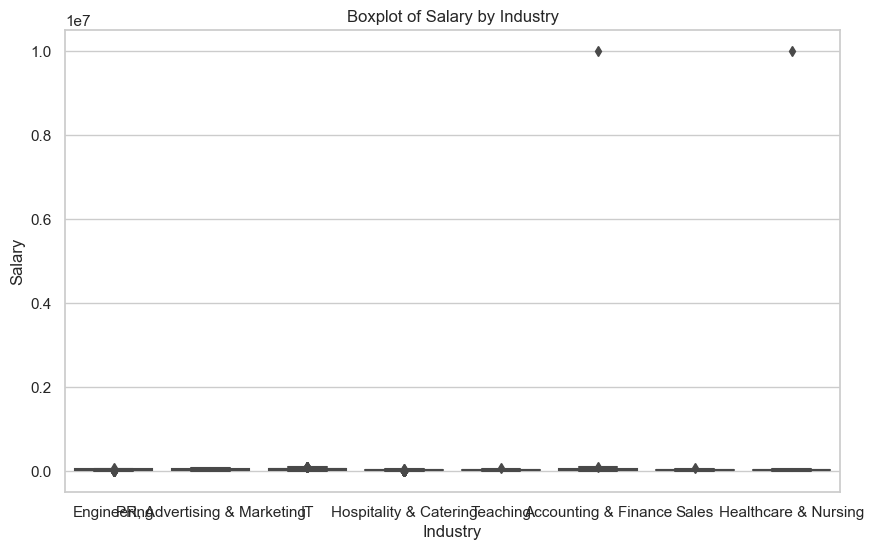

In [76]:
# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Industry', y='salary_edited', data=df)

# Set plot labels and title
plt.xlabel('Industry')
plt.ylabel('Salary')
plt.title('Boxplot of Salary by Industry')

# Show the plot
plt.show()

# We have outliers in the data, so we will remove these!!

In [77]:
# what are those $1m salaries?
df[df['salary_edited'] > 1000000]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,salary_edited,Industry
28474,69217172,Management Accountant Music Live Events / Ente...,uk,sauce recruitment,full_time,permanent,Accounting & Finance Jobs,10000000,20130418T120000,20130617T120000,britishjobsonthe.net,10000000.000000,Accounting & Finance
38926,70599036,Trainee Pharmacy Assistant,manchester,pct healthcare,full_time,non-specified,Healthcare & Nursing Jobs,10000000,20130906T150000,20131205T150000,britishjobsonthe.net,10000000.000000,Healthcare & Nursing


In [78]:
# let's null these in salary df and include them in the error list

# first let's convert the million dollar salaries edited to null
df.loc[df['salary_edited']  > 1000000, 'salary_edited'] = np.nan

In [79]:
# Calculate summary statistics
summary_stats = df.groupby('Industry')['salary_edited'].describe()

# Calculate IQR, lower bound, and upper bound for potential outliers
summary_stats['IQR'] = summary_stats['75%'] - summary_stats['25%']
summary_stats['Lower Bound'] = summary_stats['25%'] - 1.5 * summary_stats['IQR']
summary_stats['Upper Bound'] = summary_stats['75%'] + 1.5 * summary_stats['IQR']
summary_stats

,count,mean,std,min,25%,50%,75%,max,IQR,Lower Bound,Upper Bound
Industry,,,,,,,,,,,
Accounting & Finance,6527.000000,40006.135897,20502.041177,0.000000,23500.000000,35500.000000,52500.000000,108725.000000,29000.000000,-20000.000000,96000.000000
Engineering,7129.000000,33474.173236,10925.214694,0.000000,25250.000000,32500.000000,40000.000000,82181.000000,14750.000000,3125.000000,62125.000000
Healthcare & Nursing,7702.000000,30143.922072,11620.150175,0.000000,22500.000000,28000.000000,37500.000000,60000.000000,15000.000000,0.000000,60000.000000
Hospitality & Catering,4292.000000,22014.046831,7629.050676,0.000000,17000.000000,21000.000000,27000.000000,62727.000000,10000.000000,2000.000000,42000.000000
IT,12509.000000,43245.426973,17785.339205,0.000000,30000.000000,40000.000000,54000.000000,104362.000000,24000.000000,-6000.000000,90000.000000
"PR, Advertising & Marketing",2425.000000,31907.335258,12553.746911,0.000000,23500.000000,30000.000000,40000.000000,64000.000000,16500.000000,-1250.000000,64750.000000
Sales,4636.000000,28141.486454,10737.687538,0.000000,20000.000000,26500.000000,35000.000000,72181.000000,15000.000000,-2500.000000,57500.000000
Teaching,3367.000000,25828.251381,9425.724534,0.000000,19200.000000,26500.000000,32400.000000,75454.000000,13200.000000,-600.000000,52200.000000


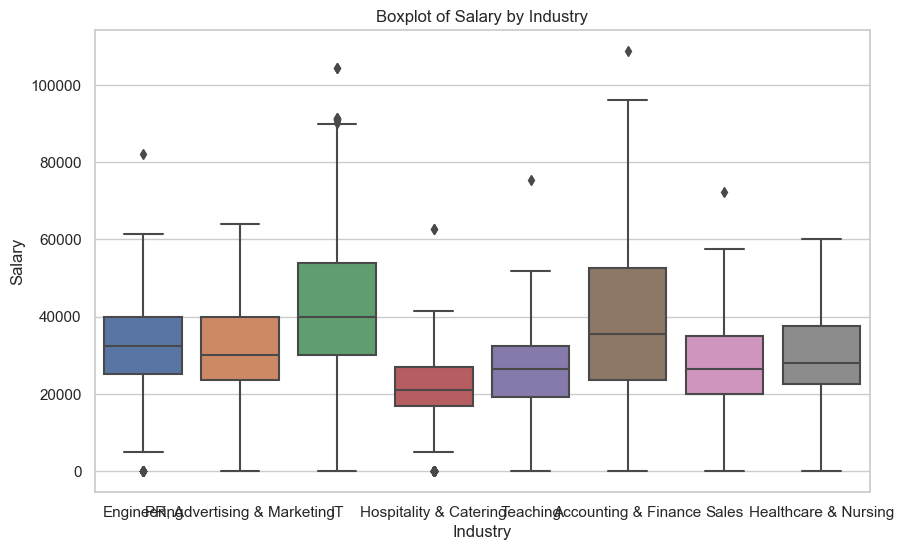

In [80]:
# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Industry', y='salary_edited', data=df)

# Set plot labels and title
plt.xlabel('Industry')
plt.ylabel('Salary')
plt.title('Boxplot of Salary by Industry')

# Show the plot
plt.show()

# Much better. But we still have zero values

In [81]:
# replace the zero values with null in the salary_edited column
df.loc[df['salary_edited'] == 0, 'salary_edited'] = np.nan

In [82]:
df['salary_edited'].isnull().sum()

2499

In [83]:
# We are going to replace the missing values in salary edited with the mean of the industry
# create a dictionary to map the mean to the industry and contract type
mean_salary = df.groupby(['Industry', 'ContractType'])['salary_edited'].mean().to_dict()
mean_salary

{('Accounting & Finance', 'full_time'): 44025.71037911747,
 ('Accounting & Finance', 'non-specified'): 39401.13944723618,
 ('Accounting & Finance', 'part_time'): 24451.616279069767,
 ('Engineering', 'full_time'): 30938.01461988304,
 ('Engineering', 'non-specified'): 34008.377221856485,
 ('Engineering', 'part_time'): 26007.8,
 ('Healthcare & Nursing', 'full_time'): 29208.26798394566,
 ('Healthcare & Nursing', 'non-specified'): 32468.786210582577,
 ('Healthcare & Nursing', 'part_time'): 22690.268079096048,
 ('Hospitality & Catering', 'full_time'): 19292.696821515892,
 ('Hospitality & Catering', 'non-specified'): 23088.99918853124,
 ('Hospitality & Catering', 'part_time'): 12716.969072164948,
 ('IT', 'full_time'): 39069.45299145299,
 ('IT', 'non-specified'): 43932.73088408289,
 ('IT', 'part_time'): 31732.894736842107,
 ('PR, Advertising & Marketing', 'full_time'): 33715.17870722433,
 ('PR, Advertising & Marketing', 'non-specified'): 31949.566433566433,
 ('PR, Advertising & Marketing', 'pa

In [84]:
# save the nan salary edited values to a dataframe for the error report.
# filter the dataframe and subset on Id and location. Then create a new column with the correct location using the dictionary
salary_nan_df = df[df['salary_edited'].isnull()][['Id','Salary']]
salary_nan_df


,Id,Salary
14,68018056,0
15,69025592,0
34,68018210,0
44,69031684,0
50,67211394,0
...,...,...
50682,72158564,
50705,72342167,
50714,72608499,-
50728,69005978,N/A


In [85]:
# replace the null values with the mean of the industry and contract type
df['salary_edited'] = df.apply(lambda x: mean_salary[(x['Industry'], x['ContractType'])] if pd.isnull(x['salary_edited']) else x['salary_edited'], axis=1)

In [86]:
# check output
df[df['Salary'] == '0'].head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,salary_edited,Industry
14,68018056,Estate Agents Administration amp; Sales HORSHAM,horsham,non-specified,non-specified,non-specified,Sales Jobs,0,20130820T000000,20130903T000000,britishjobsonthe.net,28670.300710,Sales
15,69025592,Java Developer Based Near Fareham pound;****k,fareham,non-specified,non-specified,non-specified,IT Jobs,0,20121028T000000,20121127T000000,britishjobsonthe.net,43932.730884,IT
34,68018210,Mechanical Design Engineer ****; Automotive Co...,gainsborough,non-specified,non-specified,non-specified,Engineering Jobs,0,20130219T000000,20130321T000000,britishjobsonthe.net,34008.377222,Engineering
44,69031684,"Senior Web Developer Java, Spring, Django Br...",brighton,non-specified,non-specified,non-specified,IT Jobs,0,20131227T120000,20140126T120000,britishjobsonthe.net,43932.730884,IT
50,67211394,"AREA DEVELOPMENT MANAGER, SLOUGH C pound;****...",slough,non-specified,non-specified,non-specified,Engineering Jobs,0,20120309T000000,20120508T000000,britishjobsonthe.net,34008.377222,Engineering


In [87]:
# join the correct salary_edited values to the salary_nan_df dataframe
salary_nan_df['Correct_Salary'] = salary_nan_df['Id'].map(df.set_index('Id')['salary_edited'])
salary_nan_df

,Id,Salary,Correct_Salary
14,68018056,0,28670.300710
15,69025592,0,43932.730884
34,68018210,0,34008.377222
44,69031684,0,43932.730884
50,67211394,0,34008.377222
...,...,...,...
50682,72158564,,27019.757946
50705,72342167,,32468.786211
50714,72608499,-,39069.452991
50728,69005978,N/A,32468.786211


In [88]:
# add each entry to the error log
for index, row in salary_nan_df.iterrows():
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'Salary'
                 , Orignal=row['Salary']
                 , Modified=row['Correct_Salary']
                 , ErrorType='Missing Data / Outlier'
                 , Fixing='Converted to '+str(row['Correct_Salary']))

erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified
2,72445824,Location,leads,leeds,Typographical Error,Converted to leeds
3,72160747,Location,warringtn,warrington,Typographical Error,Converted to warrington
4,69622408,Location,oxfords,oxford,Typographical Error,Converted to oxford
...,...,...,...,...,...,...
59738,72158564,Salary,,27019.757946,Missing Data / Outlier,Converted to 27019.75794621027
59739,72342167,Salary,,32468.786211,Missing Data / Outlier,Converted to 32468.786210582577
59740,72608499,Salary,-,39069.452991,Missing Data / Outlier,Converted to 39069.45299145299
59741,69005978,Salary,N/A,32468.786211,Missing Data / Outlier,Converted to 32468.786210582577


In [89]:
#check if there are any null values in salary_edited
df['salary_edited'].isnull().sum()

0

In [90]:
# copy the salary edited column into salary and remove salary_edited and industry columns
df['Salary'] = df['salary_edited']
df.drop(['salary_edited','Industry'], axis=1, inplace=True)
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,67770713,CNC Programmer (Offline),birmingham,non-specified,non-specified,non-specified,Engineering Jobs,32000.000000,20130610T150000,20130710T150000,britishjobsonthe.net
1,69026322,Weekend Engineering Team Leader,essex,non-specified,non-specified,non-specified,Engineering Jobs,39000.000000,20120515T120000,20120529T120000,britishjobsonthe.net
2,67770033,Junior Writer,nottingham,non-specified,non-specified,non-specified,"PR, Advertising & Marketing Jobs",16500.000000,20130617T000000,20130717T000000,britishjobsonthe.net
3,69025763,Net Developer Manchester (Up To pound;****K ...,manchester,non-specified,non-specified,non-specified,IT Jobs,38000.000000,20120221T120000,20120306T120000,britishjobsonthe.net
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,bath,non-specified,non-specified,non-specified,Hospitality & Catering Jobs,16000.000000,20130327T150000,20130410T150000,britishjobsonthe.net


In [91]:
df['Salary'].isnull().sum()

0

### 2.9 Cleaning Open and Close Date Fields

In [92]:
# Function to convert date/time format
def convert_datetime(datetime_str):
    try:
        # Convert input format to datetime object
        dt_object = datetime.strptime(datetime_str, '%Y%m%dT%H%M%S')
        
        # Convert datetime object to desired format
        return dt_object.strftime('%Y-%m-%d %H:%M:%S')
    except ValueError as e:
        # Handle the error: Set the value to None and add to the error DataFrame
        time_error_df.loc[len(time_error_df)] = [datetime_str, str(e)]
        return None

# Create an error DataFrame to collect erroneous dates
time_error_df = pd.DataFrame(columns=['Original_Date', 'Error_Message'])

# Apply the function to 'OpenDate' and 'CloseDate' columns
df['OpenDate_edited'] = df['OpenDate'].apply(convert_datetime)
df['CloseDate_edited'] = df['CloseDate'].apply(convert_datetime)
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,OpenDate_edited,CloseDate_edited
0,67770713,CNC Programmer (Offline),birmingham,non-specified,non-specified,non-specified,Engineering Jobs,32000.000000,20130610T150000,20130710T150000,britishjobsonthe.net,2013-06-10 15:00:00,2013-07-10 15:00:00
1,69026322,Weekend Engineering Team Leader,essex,non-specified,non-specified,non-specified,Engineering Jobs,39000.000000,20120515T120000,20120529T120000,britishjobsonthe.net,2012-05-15 12:00:00,2012-05-29 12:00:00
2,67770033,Junior Writer,nottingham,non-specified,non-specified,non-specified,"PR, Advertising & Marketing Jobs",16500.000000,20130617T000000,20130717T000000,britishjobsonthe.net,2013-06-17 00:00:00,2013-07-17 00:00:00
3,69025763,Net Developer Manchester (Up To pound;****K ...,manchester,non-specified,non-specified,non-specified,IT Jobs,38000.000000,20120221T120000,20120306T120000,britishjobsonthe.net,2012-02-21 12:00:00,2012-03-06 12:00:00
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,bath,non-specified,non-specified,non-specified,Hospitality & Catering Jobs,16000.000000,20130327T150000,20130410T150000,britishjobsonthe.net,2013-03-27 15:00:00,2013-04-10 15:00:00


In [93]:
# map id to the time error list
time_error_df

,Original_Date,Error_Message
0,20133001T000000,time data '20133001T000000' does not match for...


In [94]:
# filter df where open date time or close date time is in time_error_df
time_error_df2 = df[df['OpenDate'].isin(time_error_df['Original_Date']) | df['CloseDate'].isin(time_error_df['Original_Date'])]
time_error_df2

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,OpenDate_edited,CloseDate_edited
49073,69557854,"VBNet Developer, SQL",liverpool,monarch recruitment,non-specified,permanent,IT Jobs,31250.000000,20133001T000000,20130430T000000,britishjobsonthe.net,None,2013-04-30 00:00:00


In [95]:
# replace incorrect open date '20133001T000000' with the correct date
df.loc[df['Id'] == 69557854, 'OpenDate_edited'] = '2013-03-01 00:00:00'


In [96]:
df[df['Id'] == 69557854]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,OpenDate_edited,CloseDate_edited
49073,69557854,"VBNet Developer, SQL",liverpool,monarch recruitment,non-specified,permanent,IT Jobs,31250.000000,20133001T000000,20130430T000000,britishjobsonthe.net,2013-03-01 00:00:00,2013-04-30 00:00:00


In [97]:
# update error list for incorrect time
updateErlist(indexOfdf=50870368
                 , ColumnName= 'OpenDate'
                 , Orignal='20133001T000000'
                 , Modified='2013-03-01 00:00:00'
                 , ErrorType='Typographical Error'
                 , Fixing='Converted to 2013-03-01 00:00:00')

In [98]:
erlist

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
0,50870368,Title,****,non-specified,Typographical Error,Converted to non-specified
1,68584140,Title,test,non-specified,Data Imputation Error,Converted to non-specified
2,72445824,Location,leads,leeds,Typographical Error,Converted to leeds
3,72160747,Location,warringtn,warrington,Typographical Error,Converted to warrington
4,69622408,Location,oxfords,oxford,Typographical Error,Converted to oxford
...,...,...,...,...,...,...
59739,72342167,Salary,,32468.786211,Missing Data / Outlier,Converted to 32468.786210582577
59740,72608499,Salary,-,39069.452991,Missing Data / Outlier,Converted to 39069.45299145299
59741,69005978,Salary,N/A,32468.786211,Missing Data / Outlier,Converted to 32468.786210582577
59742,72650920,Salary,-,43932.730884,Missing Data / Outlier,Converted to 43932.73088408289


In [99]:
# check that close date is greater than open date
time_logic_err = df[df['CloseDate_edited'] < df['OpenDate_edited']]
time_logic_err

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,OpenDate_edited,CloseDate_edited
2010,68082414,Care Assistant Donnington and Surrounding areas,chichester,saga homecare,non-specified,permanent,Healthcare & Nursing Jobs,16800.000000,20131201T000000,20131002T000000,britishjobsonthe.net,2013-12-01 00:00:00,2013-10-02 00:00:00
9520,71672057,Client Services Administrator (12 month Contract),uk,margaret hodge recruitment,non-specified,contract,Accounting & Finance Jobs,22000.000000,20120220T000000,20120121T000000,britishjobsonthe.net,2012-02-20 00:00:00,2012-01-21 00:00:00
12846,67308229,IP Network Engineer Juniper JNCIA JNCIS x,reading,jam recruitment,non-specified,permanent,IT Jobs,50000.000000,20131123T120000,20131024T120000,britishjobsonthe.net,2013-11-23 12:00:00,2013-10-24 12:00:00
25069,69544626,Credit Risk Portfolio Manager,london,sec recruitment,non-specified,permanent,IT Jobs,55000.000000,20130503T150000,20130304T150000,britishjobsonthe.net,2013-05-03 15:00:00,2013-03-04 15:00:00
30870,70293367,Senior HR Advisor 12 Month FTC,slough,evolve hospitality,non-specified,non-specified,Hospitality & Catering Jobs,32500.000000,20120413T000000,20120330T000000,britishjobsonthe.net,2012-04-13 00:00:00,2012-03-30 00:00:00


In [100]:
# add these to the error list and replace the close date with the open date
for index, row in time_logic_err.iterrows():
    # Open Date
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'OpenDate'
                 , Orignal=row['OpenDate']
                 , Modified=row['CloseDate']
                 , ErrorType='Logical Error'
                 , Fixing='Converted to '+str(row['CloseDate']))
    # Close Date
    updateErlist(indexOfdf=row['Id']
                 , ColumnName= 'CloseDate'
                 , Orignal=row['CloseDate']
                 , Modified=row['OpenDate']
                 , ErrorType='Logical Error'
                 , Fixing='Converted to '+str(row['OpenDate']))
    

In [101]:
erlist.tail(10)

,indexOfdf,ColumnName,Orignal,Modified,ErrorType,Fixing
59744,68082414,OpenDate,20131201T000000,20131002T000000,Logical Error,Converted to 20131002T000000
59745,68082414,CloseDate,20131002T000000,20131201T000000,Logical Error,Converted to 20131201T000000
59746,71672057,OpenDate,20120220T000000,20120121T000000,Logical Error,Converted to 20120121T000000
59747,71672057,CloseDate,20120121T000000,20120220T000000,Logical Error,Converted to 20120220T000000
59748,67308229,OpenDate,20131123T120000,20131024T120000,Logical Error,Converted to 20131024T120000
59749,67308229,CloseDate,20131024T120000,20131123T120000,Logical Error,Converted to 20131123T120000
59750,69544626,OpenDate,20130503T150000,20130304T150000,Logical Error,Converted to 20130304T150000
59751,69544626,CloseDate,20130304T150000,20130503T150000,Logical Error,Converted to 20130503T150000
59752,70293367,OpenDate,20120413T000000,20120330T000000,Logical Error,Converted to 20120330T000000
59753,70293367,CloseDate,20120330T000000,20120413T000000,Logical Error,Converted to 20120413T000000


In [102]:
# this for loop iterates over the time_logic_err dataframe and updates the df dataframe with the correct open and close dates
# if the Id is in the time_logic_err, then update the time fields otherwise leave as is

for index, row in time_logic_err.iterrows():
    if row['Id'] in time_logic_err['Id']:
        df.loc[df['Id'] == row['Id'], 'OpenDate_edited'] = row['CloseDate_edited']
        df.loc[df['Id'] == row['Id'], 'CloseDate_edited'] = row['OpenDate_edited']
    else:
        continue

In [103]:
# check the df where the index is in time_logic_err
df[df['Id'].isin(time_logic_err['Id'])]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,OpenDate_edited,CloseDate_edited
2010,68082414,Care Assistant Donnington and Surrounding areas,chichester,saga homecare,non-specified,permanent,Healthcare & Nursing Jobs,16800.000000,20131201T000000,20131002T000000,britishjobsonthe.net,2013-12-01 00:00:00,2013-10-02 00:00:00
9520,71672057,Client Services Administrator (12 month Contract),uk,margaret hodge recruitment,non-specified,contract,Accounting & Finance Jobs,22000.000000,20120220T000000,20120121T000000,britishjobsonthe.net,2012-02-20 00:00:00,2012-01-21 00:00:00
12846,67308229,IP Network Engineer Juniper JNCIA JNCIS x,reading,jam recruitment,non-specified,permanent,IT Jobs,50000.000000,20131123T120000,20131024T120000,britishjobsonthe.net,2013-11-23 12:00:00,2013-10-24 12:00:00
25069,69544626,Credit Risk Portfolio Manager,london,sec recruitment,non-specified,permanent,IT Jobs,55000.000000,20130503T150000,20130304T150000,britishjobsonthe.net,2013-05-03 15:00:00,2013-03-04 15:00:00
30870,70293367,Senior HR Advisor 12 Month FTC,slough,evolve hospitality,non-specified,non-specified,Hospitality & Catering Jobs,32500.000000,20120413T000000,20120330T000000,britishjobsonthe.net,2012-04-13 00:00:00,2012-03-30 00:00:00


In [104]:
df[df['OpenDate'].isna()]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName,OpenDate_edited,CloseDate_edited


In [105]:
# replace the open and close date with the edited version
df['OpenDate'] = df['OpenDate_edited']
df['CloseDate'] = df['CloseDate_edited']

# remove the edited versions
df.drop(['OpenDate_edited','CloseDate_edited'], axis=1, inplace=True)

In [106]:
df['OpenDate'].isnull().sum()

0

In [107]:
df['CloseDate'].isna().sum()

0

In [108]:
df.head(10)

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,67770713,CNC Programmer (Offline),birmingham,non-specified,non-specified,non-specified,Engineering Jobs,32000.000000,2013-06-10 15:00:00,2013-07-10 15:00:00,britishjobsonthe.net
1,69026322,Weekend Engineering Team Leader,essex,non-specified,non-specified,non-specified,Engineering Jobs,39000.000000,2012-05-15 12:00:00,2012-05-29 12:00:00,britishjobsonthe.net
2,67770033,Junior Writer,nottingham,non-specified,non-specified,non-specified,"PR, Advertising & Marketing Jobs",16500.000000,2013-06-17 00:00:00,2013-07-17 00:00:00,britishjobsonthe.net
3,69025763,Net Developer Manchester (Up To pound;****K ...,manchester,non-specified,non-specified,non-specified,IT Jobs,38000.000000,2012-02-21 12:00:00,2012-03-06 12:00:00,britishjobsonthe.net
4,68017718,Chef De Partie pound;****gratutities****AA Ros...,bath,non-specified,non-specified,non-specified,Hospitality & Catering Jobs,16000.000000,2013-03-27 15:00:00,2013-04-10 15:00:00,britishjobsonthe.net
5,69024820,Packaging Analyst,cheshire,non-specified,non-specified,non-specified,Teaching Jobs,30000.000000,2013-11-12 12:00:00,2013-12-12 12:00:00,britishjobsonthe.net
6,68017533,Client Support Technician Fleet twentyfour/s...,fleet,non-specified,non-specified,non-specified,IT Jobs,24000.000000,2012-08-26 12:00:00,2012-10-25 12:00:00,britishjobsonthe.net
7,67769728,**** X PLater amp; **** X Welder MIG/TIG/MMA,sheffield,non-specified,non-specified,non-specified,Engineering Jobs,24960.000000,2013-07-15 15:00:00,2013-09-13 15:00:00,britishjobsonthe.net
8,67210970,"JUNIOR M amp;E PROJECT ENGINEER, ASHFORD, KENT...",ashford,non-specified,non-specified,non-specified,Engineering Jobs,26000.000000,2012-03-20 00:00:00,2012-04-19 00:00:00,britishjobsonthe.net
9,69025432,Acquisitions Manager Telephony And Direct Mail,gloucester,non-specified,non-specified,non-specified,Accounting & Finance Jobs,47565.000000,2012-09-29 00:00:00,2012-10-13 00:00:00,britishjobsonthe.net


In [109]:
df.tail(10)

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
50743,72531462,EI/POS net developer,uk,jobg8,non-specified,non-specified,IT Jobs,60000.000000,2013-04-08 12:00:00,2013-06-07 12:00:00,britishjobsonthe.net
50744,71280413,Project Manager / Payments (essential) / Watford,uk,rdf,non-specified,permanent,IT Jobs,70000.000000,2013-10-05 15:00:00,2013-11-04 15:00:00,britishjobsonthe.net
50745,68849008,Corporate Facilities Manager,uk,rdf,non-specified,permanent,IT Jobs,50000.000000,2012-06-18 15:00:00,2012-07-18 15:00:00,britishjobsonthe.net
50746,70570237,Technology Consultant Financial Services,london,links resourcing,non-specified,permanent,IT Jobs,40000.000000,2012-02-01 15:00:00,2012-05-01 15:00:00,britishjobsonthe.net
50747,67142856,Senior Business Analyst Data Mining,uk,global payments network,non-specified,permanent,IT Jobs,50000.000000,2012-01-30 12:00:00,2012-02-29 12:00:00,britishjobsonthe.net
50748,68704692,Graduate SoftwareWeb Developer,london,unknown auto added by vacany import,non-specified,non-specified,IT Jobs,25000.000000,2012-01-12 12:00:00,2012-03-12 12:00:00,britishjobsonthe.net
50749,72653751,Barclays Future Leaders Development Programmes,hackney,barclays,non-specified,non-specified,IT Jobs,36000.000000,2013-07-21 15:00:00,2013-09-19 15:00:00,britishjobsonthe.net
50750,72420369,Graduate Operations Technical Analyst,hungerford,unknown auto added by vacany import,non-specified,non-specified,IT Jobs,23000.000000,2013-09-13 15:00:00,2013-11-12 15:00:00,britishjobsonthe.net
50751,72653749,GCHQ Graduate Technologists various roles,cheltenham,gchq,non-specified,non-specified,Engineering Jobs,25400.000000,2012-04-12 00:00:00,2012-06-11 00:00:00,britishjobsonthe.net
50752,66372417,Graduate Engineer (Water industry),south lanarkshire,carrington west,full_time,contract,Engineering Jobs,20000.000000,2013-01-19 00:00:00,2013-04-19 00:00:00,britishjobsonthe.net


## Saving data
Save the parsed and cleaned data as well as the error list, named as:
- \<student\_id\>_dataset1_solution.csv
- \<student\_id\>_errorlist.csv

In [110]:
# Export the df and the error list into csv format
df.to_csv('s3932835_dataset1_solution.csv', index=False)
erlist.to_csv('s3932835_errorlist.csv', index=False)


## Conclusion

In conclusion, the tasks of parsing and data cleaning undertaken in this exercise were both challenging and rewarding. The goal of the assignment was to transform a raw XML file containing job posting information into a specific format as outlined in the assignment description. However, there were numerous problems along the way that required diligent data cleaning and adjustment.

One of the significant challenges we faced was accommodating the varying structure of XML records. Not all records included all fields, leading to missing data for some entries. I approached this issue by adjusting the parsing methods to handle these inconsistencies effectively.

Cleaning string fields, such as the job title, company title and location, was another crucial aspect of the data cleaning effort. There were job titles with numbers and incorrect text, such as 'test' or '***' which needed to be rectified to ensure data accuracy. To tackle this, I used similarity scores to identify unusual strings and used the most appropriate similar score for a meaningful and sensible replacement. Similarity scores helped automate the process of correcting misspelled locations, saving considerable manual effort across 50 thousand entries.

Numerical data presented its own set of challenges, including different units of measure and entries. I used regular expressions to identify the different units of measure and then built functions to normalise the data. 

Throughout this exercise, I used univariate analysis to gain insights into the distribution of various fields, including salary and date/time information. This helped identify outliers and logical errors that needed correction.

In summary, the combination of parsing and data cleaning techniques allowed us to transform a complex XML dataset into a clean, structured format, meeting the objectives outlined in the assignment description. While the project presented its share of challenges, the resulting dataset is now well-prepared for Task 3.